<a href="https://colab.research.google.com/github/danielabebe1/Capstone2/blob/master/Final_Notebook_Predict_lung_function_decline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predict Lung Function Decline (Pulmonary Fibrosis)



Pulmonary fibrosis is a lung disease that occurs when lung tissue becomes damaged and scarred. The word “pulmonary” means lung and the word “fibrosis” means scar tissue— similar to scars that you may have on your skin from an old injury or surgery.The scar tissue thickened, stiff tissue makes it more difficult for the lungs to work properly as shown in Fig 1. As pulmonary fibrosis worsens, it becomes progressively more short of breath. As of now pulmonary fibrosis has no treatment but some medications and therapies help to improve quality of life.

## Importing libraries

In [ ]:
!pip install pydicom
import numpy as np
import random
import pandas as pd
import seaborn as sns
import re
import pydicom as dicom
import os
import matplotlib.pyplot as plt
import glob
from tqdm.notebook import tqdm 

import warnings
from termcolor import colored
warnings.filterwarnings('ignore')
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
import cv2
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.utils import Sequence
from tensorflow_addons.optimizers import RectifiedAdam
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
from tensorflow.keras.layers import (
    Dense, Dropout, Activation, Flatten, Input, GlobalAveragePooling2D, Add, Conv2D, AveragePooling2D, 
    LeakyReLU, Concatenate, BatchNormalization)

from skimage import morphology
from skimage import measure
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error
from skimage.transform import resize
from sklearn.cluster import KMeans
from skimage import measure, morphology
plt.show()


In [ ]:
def seed_everything(seed=100):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
seed_everything(101)

## Uploading datasets

In [ ]:
#connect google drive to google colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#using the directories for each files
# !pip install colorama
#Directories
train_dir='/content/drive/My Drive/OSIC Pulmonary Fibrosis/train/'
patients=os.listdir(train_dir)
patients.sort()
test_dir='/content/drive/My Drive/OSIC Pulmonary Fibrosis/test/'
train_csv='/content/drive/My Drive/OSIC Pulmonary Fibrosis/train.csv'
test_csv='/content/drive/My Drive/OSIC Pulmonary Fibrosis/test.csv'
sub_csv='/content/drive/My Drive/OSIC Pulmonary Fibrosis/sample_submission.csv'
#read csv
df_train=pd.read_csv(train_csv)
df_test=pd.read_csv(test_csv)
df_sub=pd.read_csv(sub_csv)
df_sub['Weeks']   = df_sub['Patient_Week'].apply( lambda x: int(x.split('_')[-1]) )
df_sub['Patient'] = df_sub['Patient_Week'].apply( lambda x: x.split('_')[0] )

In [ ]:
#take a look at top five dataset
df_train.head()

Patient  Weeks   FVC    Percent  Age   Sex SmokingStatus
0  ID00007637202177411956430     -4  2315  58.253649   79  Male     Ex-smoker
1  ID00007637202177411956430      5  2214  55.712129   79  Male     Ex-smoker
2  ID00007637202177411956430      7  2061  51.862104   79  Male     Ex-smoker
3  ID00007637202177411956430      9  2144  53.950679   79  Male     Ex-smoker
4  ID00007637202177411956430     11  2069  52.063412   79  Male     Ex-smoker

Let's see the patient ID's both in training and test as well as in the submission dataset.

In [ ]:
print('The shape of traing data: ' + str(df_train.shape))

The shape of traing data: (1549, 7)


In [ ]:
#check missing values
print('Do null values exist in the dataset? ' + str(df_train.isnull().values.any()))

Do null values exist in the dataset? False


In [ ]:
# df_train.reset_index(inplace = True , drop = True)
# patient_df.reset_index(inplace = True , drop = True)
# df_test.reset_index(inplace = True , drop = True)

## **Exploratory data analysis(EDA)**


In [ ]:
#From the statistic summary, there are 176 unique patiets
df_train.describe(include='all')

Patient        Weeks  ...   Sex  SmokingStatus
count                        1549  1549.000000  ...  1549           1549
unique                        176          NaN  ...     2              3
top     ID00167637202237397919352          NaN  ...  Male      Ex-smoker
freq                           10          NaN  ...  1224           1038
mean                          NaN    31.861846  ...   NaN            NaN
std                           NaN    23.247550  ...   NaN            NaN
min                           NaN    -5.000000  ...   NaN            NaN
25%                           NaN    12.000000  ...   NaN            NaN
50%                           NaN    28.000000  ...   NaN            NaN
75%                           NaN    47.000000  ...   NaN            NaN
max                           NaN   133.000000  ...   NaN            NaN

[11 rows x 7 columns]

Looking at the statistics of train data, there are 176 patients which means that each patient has approximatly 9 records. The maximum number of record is 10 and minimum number is 6.

In [ ]:
print("Lowest number of record : ",df_train["Patient"].value_counts().sort_values(ascending=True).head(1))
print("Average number of record : ",df_train["Patient"].value_counts().mean())
print("Highest number of records: ",df_train["Patient"].value_counts().sort_values(ascending=True).tail(1))

Lowest number of record :  ID00267637202270790561585    6
Name: Patient, dtype: int64
Average number of record :  8.801136363636363
Highest number of records:  ID00167637202237397919352    10
Name: Patient, dtype: int64


In [ ]:
(unique, counts) = np.unique(df_train['Patient'].value_counts().values, return_counts=True)
frequencies = np.asarray((unique, counts)).T
unique_count=pd.DataFrame(frequencies, columns=['# of Entries per Patient', "Entries's Count"])
unique_count

# of Entries per Patient  Entries's Count
0                         6                2
1                         7                7
2                         8               25
3                         9              132
4                        10               10

Text(0.5, 1.0, 'The frequency of unique entries per patient')

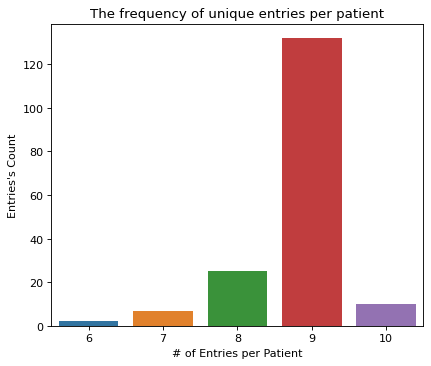

In [ ]:
plt.figure(figsize=(6,5), dpi= 80)
sns.barplot(x=unique_count['# of Entries per Patient'], y=unique_count["Entries's Count"])
plt.title('The frequency of unique entries per patient')

In [ ]:
df_train.columns
#take detail of unique patients: Patient, Age, Sex and SmokingStatus. Other attributes such as 'Weeks', 'FVC', 'Percent',
#are measurement
cols=['Patient','Age','Sex','SmokingStatus']
unique_patient = df_train[['Patient', 'Age', 'Sex', 'SmokingStatus']].drop_duplicates()
unique_patient.head()

Patient  Age   Sex SmokingStatus
0   ID00007637202177411956430   79  Male     Ex-smoker
9   ID00009637202177434476278   69  Male     Ex-smoker
18  ID00010637202177584971671   60  Male     Ex-smoker
27  ID00011637202177653955184   72  Male     Ex-smoker
36  ID00012637202177665765362   65  Male  Never smoked

- 79% of the patients are male and 21% female. 
- the majority of patients are ex-smokers with 67% and patients who never smoke are 28%, current smokers are only 5%
- Ex-smokers 90% are male and 10% are female
- Never smoked 53% male and 47% female
- Current skokers 78% male and 22% female


In [ ]:
#calculate the gender distriction in the train dataset
print("Male persentage in dataset: ",df_train[df_train["Sex"]=="Male"].shape[0]*100/len(df_train))
print("Female persentage in dataset: ",df_train[df_train["Sex"]=="Female"].shape[0]*100/len(df_train))

Male persentage in dataset:  79.0187217559716
Female persentage in dataset:  20.981278244028406


In [ ]:
#classifying the smoking status 
print("Percent of Ex-smoker: ",df_train[df_train["SmokingStatus"]=="Ex-smoker"].shape[0]*100/len(df_train))
print("Percent of Never a smoker: ",df_train[df_train["SmokingStatus"]=="Never smoked"].shape[0]*100/len(df_train))
print("Percent of Currently smokes: ",df_train[df_train['SmokingStatus']=="Currently smokes"].shape[0]*100/len(df_train))

Percent of Ex-smoker:  67.01097482246611
Percent of Never a smoker:  27.695287282117494
Percent of Currently smokes:  5.293737895416398


In [ ]:
df_train[df_train['SmokingStatus']=='Ex-smoker']['Sex'].value_counts()*100/len(df_train[df_train['SmokingStatus']=='Ex-smoker'])

Male      89.691715
Female    10.308285
Name: Sex, dtype: float64

In [ ]:
df_train[df_train['SmokingStatus']=='Never smoked']['Sex'].value_counts()*100/len(df_train[df_train['SmokingStatus']=='Never smoked'])

Male      53.379953
Female    46.620047
Name: Sex, dtype: float64

In [ ]:
df_train[df_train['SmokingStatus']=='Currently smokes']['Sex'].value_counts()*100/len(df_train[df_train['SmokingStatus']=='Currently smokes'])

Male      78.04878
Female    21.95122
Name: Sex, dtype: float64

Text(0.5, 1.0, 'Ratio of Gender')

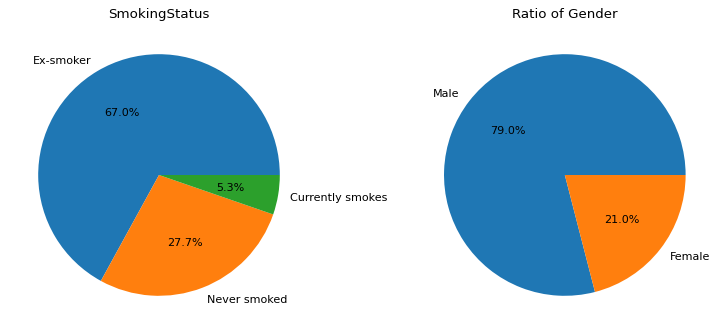

In [ ]:
# Draw a pie chart about smoking status
plt.figure(figsize=(12,5), dpi= 80)
plt.subplot(1, 2, 1)
plt.pie(df_train["SmokingStatus"].value_counts(),labels=["Ex-smoker","Never smoked","Currently smokes"],autopct="%.1f%%")
plt.title("SmokingStatus")
# Draw a pie chart about gender.
plt.subplot(1, 2, 2)
plt.pie(df_train["Sex"].value_counts(),labels=["Male","Female"],autopct="%.1f%%")
plt.title("Ratio of Gender")

The FVC,Percent, Weeks age distributed between 49 and 88 with mean 67. Looking at the distribution plot below, uniform with a little swewness to the left.

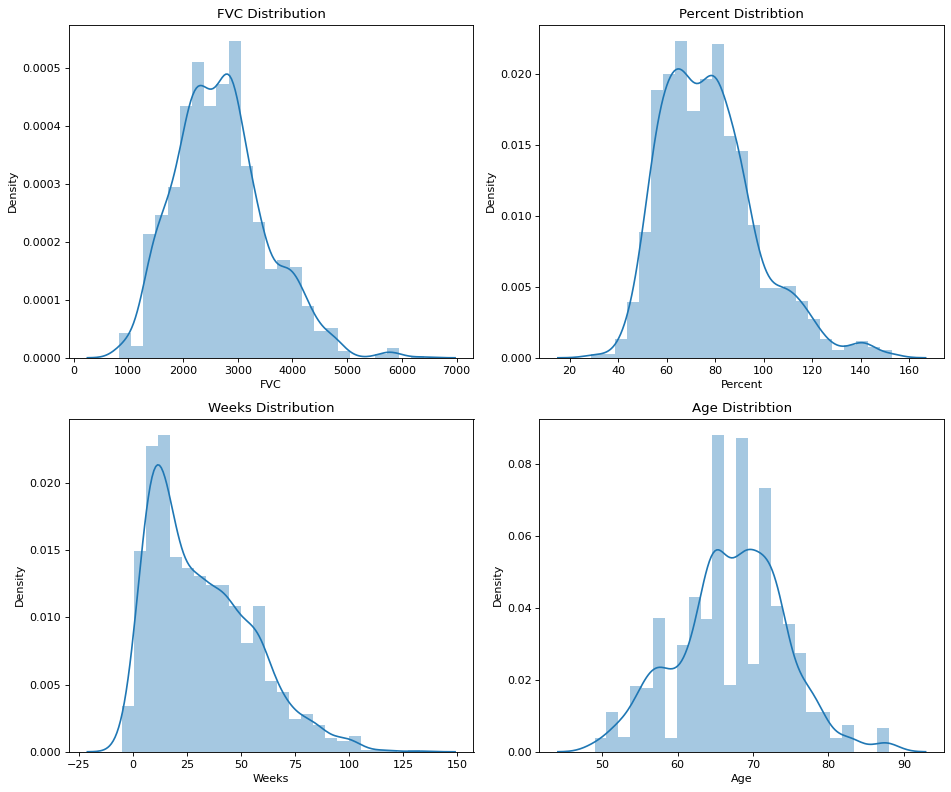

In [ ]:
plt.figure(figsize=(12,10), dpi= 80)
plt.subplot(2, 2, 1)
sns.distplot(df_train['FVC'], bins=25, kde=True).set_title('FVC Distribution')
plt.subplot(2, 2, 2)
sns.distplot(df_train['Percent'], bins=25,kde=True).set_title('Percent Distribtion')
plt.subplot(2, 2, 3)
sns.distplot(df_train['Weeks'], bins=25, kde=True).set_title('Weeks Distribution')
plt.subplot(2, 2, 4)
sns.distplot(df_train['Age'], bins=25,kde=True).set_title('Age Distribtion')
plt.tight_layout()


Forced vital capacity (FVC) is the recorded lung capacity in ml which is defined as the amount of air that can be forcibly exhaled from your lungs after taking the deepest breath possible, as measured by spirometry.




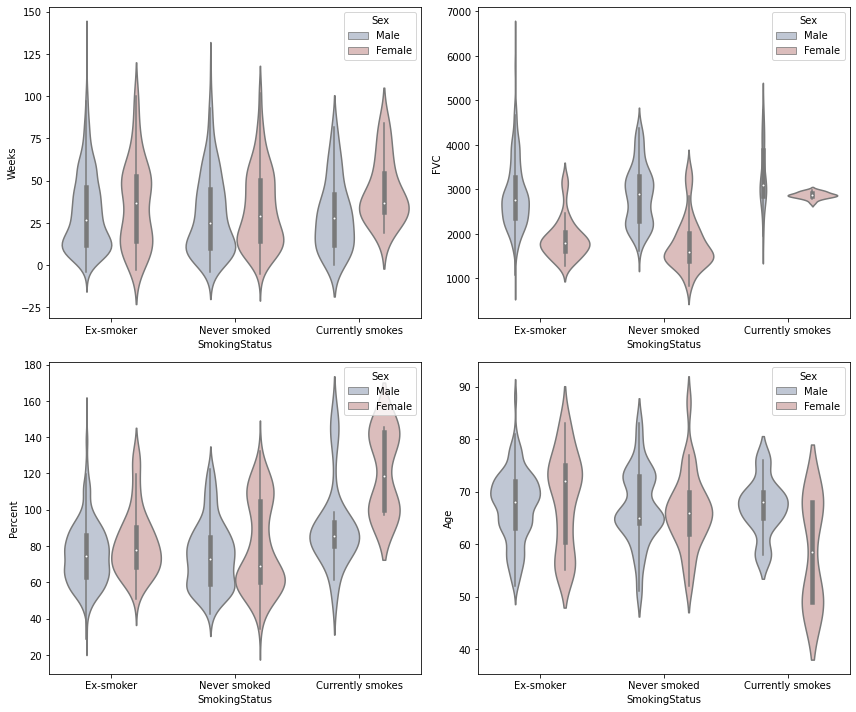

In [ ]:
f, axes = plt.subplots(2, 2,figsize=(12, 10), sharex=False)
sns.violinplot(x="SmokingStatus",y="Weeks",data=df_train, palette="vlag", hue='Sex',orient='v' , ax=axes[0, 0])
sns.violinplot(x="SmokingStatus",y="FVC",data=df_train, palette="vlag", hue='Sex',orient='v' , ax=axes[0, 1])
sns.violinplot(x="SmokingStatus",y="Percent",data=df_train, palette="vlag", hue='Sex',orient='v' , ax=axes[1, 0])
sns.violinplot(x="SmokingStatus",y="Age",data=df_train, palette="vlag", hue='Sex',orient='v' , ax=axes[1, 1])
plt.tight_layout()

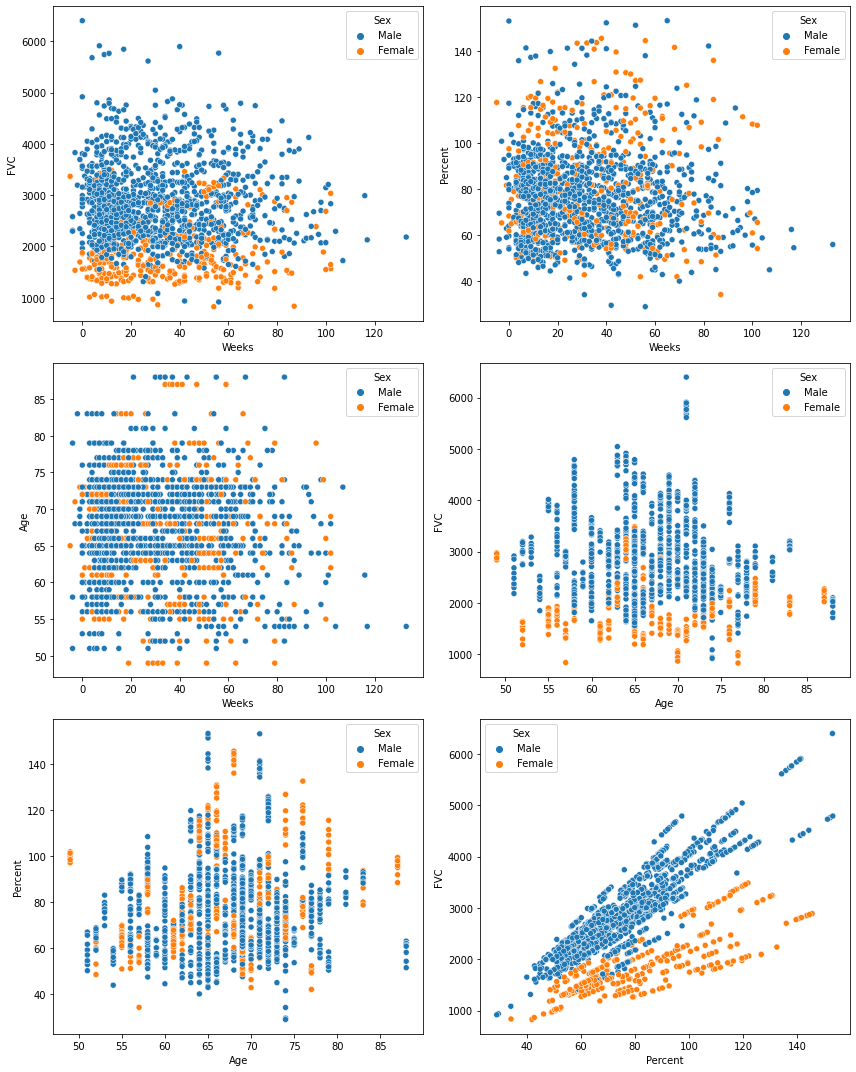

In [ ]:
f, axes = plt.subplots(3, 2,figsize=(12, 15), sharex=False)
sns.scatterplot(x='Weeks', y='FVC', data=df_train, hue='Sex', ax=axes[0,0])
sns.scatterplot(x='Weeks', y='Percent', data=df_train, hue='Sex', ax=axes[0,1])
sns.scatterplot(x='Weeks', y='Age', data=df_train, hue='Sex', ax=axes[1,0])
sns.scatterplot(x='Age', y='FVC', data=df_train, hue='Sex', ax=axes[1,1])
sns.scatterplot(x='Age', y='Percent', data=df_train, hue='Sex', ax=axes[2,0])
sns.scatterplot(x='Percent', y='FVC', data=df_train, hue='Sex', ax=axes[2,1])
plt.tight_layout()


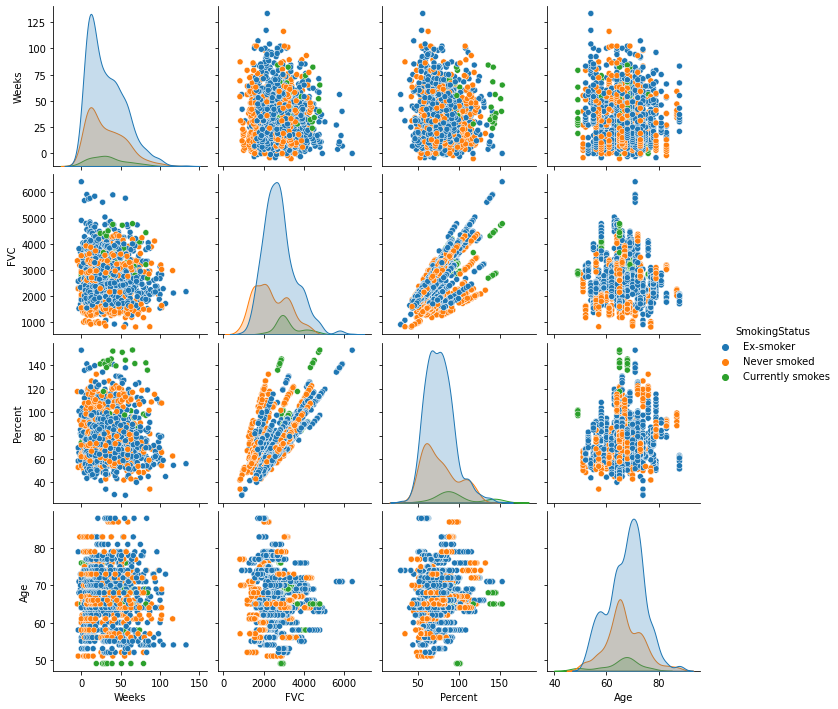

In [ ]:
sns.pairplot(df_train, hue='SmokingStatus')

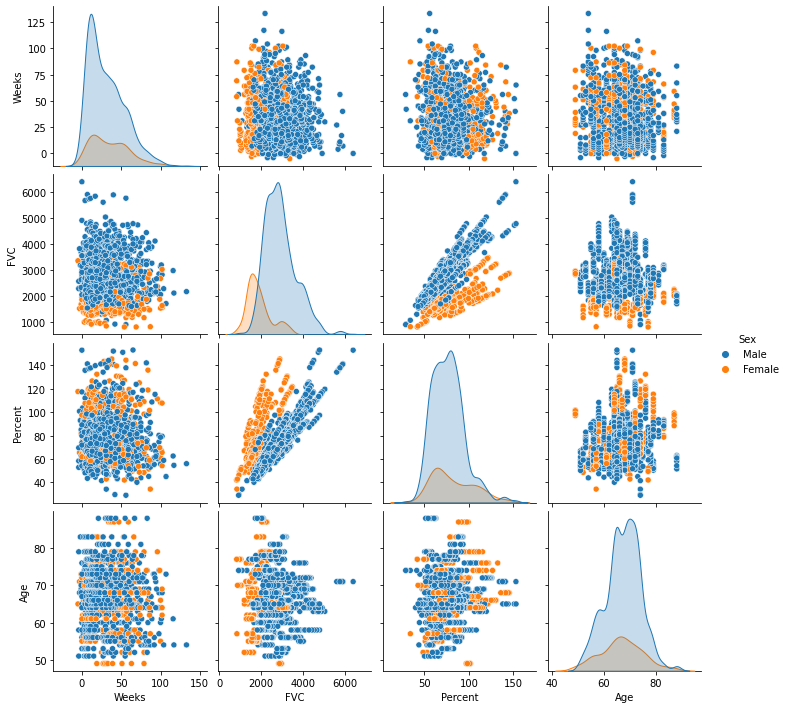

In [ ]:
sns.pairplot(df_train, hue='Sex')

In [ ]:
new_df = df_train.groupby([df_train.Patient,df_train.Age,df_train.Sex, df_train.SmokingStatus])['Patient'].count()
new_df.index = new_df.index.set_names(['id','Age','Sex','SmokingStatus'])
new_df = new_df.reset_index()
new_df.rename(columns = {'Patient': 'freq'},inplace = True)

new_df.head()

id  Age   Sex SmokingStatus  freq
0  ID00007637202177411956430   79  Male     Ex-smoker     9
1  ID00009637202177434476278   69  Male     Ex-smoker     9
2  ID00010637202177584971671   60  Male     Ex-smoker     9
3  ID00011637202177653955184   72  Male     Ex-smoker     9
4  ID00012637202177665765362   65  Male  Never smoked     9

Text(0.5, 1.0, 'Age distribution')

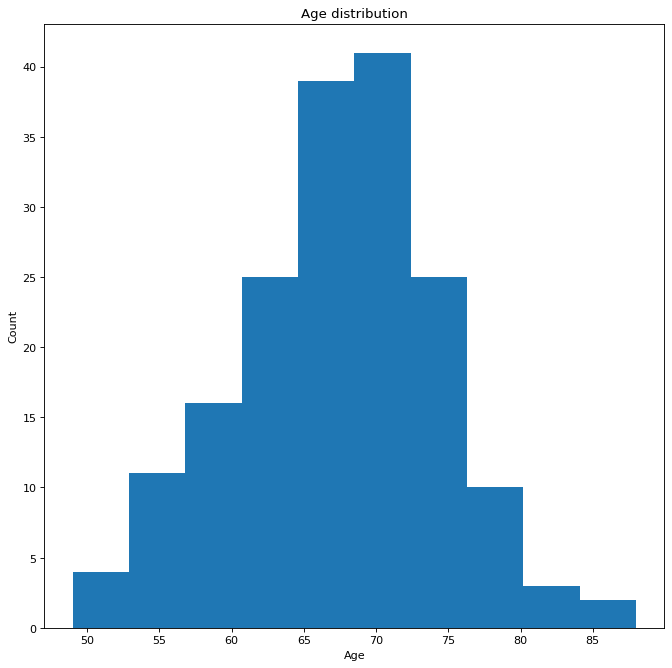

In [ ]:
plt.figure(figsize=(10,10), dpi= 80)
plt.hist('Age',data=new_df)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age distribution')

Using a heatmap, a two-dimensional graphical representation of data where the individual values that are contained in a matrix are represented as colors, shows the correlation between numerical features.

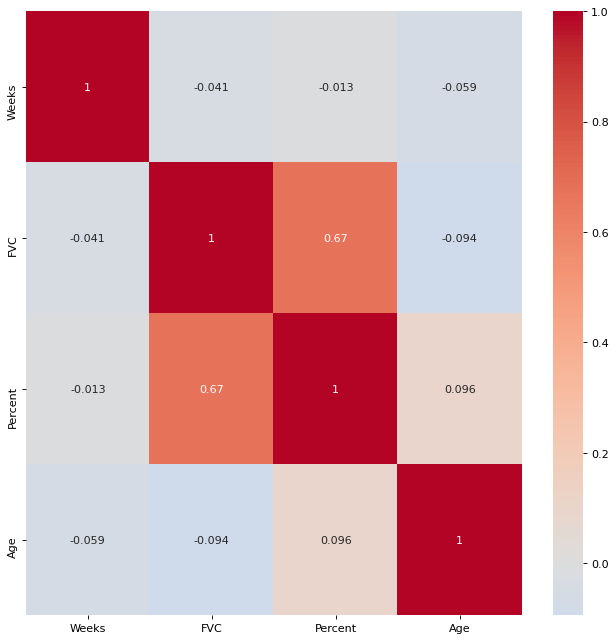

In [ ]:
#Correlation using heatmap
plt.figure(figsize=(10,10), dpi= 80)
df_cor=df_train.corr()
hm=sns.heatmap(df_cor, annot=True,center = 0,cmap='coolwarm', cbar=True)


In order to grasp all possible features from the dataset, let's merge the CSV file of train dataset, test dataset and Submission dataset files

## Data Wranglling and EDA of DICOM files

The images are in DICOM format. DICOM stands for Digital Imaging and Communications in Medicine. Wikipidea defines DICOM as: it is the standard for the communication and management of medical imaging information and related data. DICOM is most commonly used for storing and transmitting medical images enabling the integration of medical imaging devices such as scanners, servers, workstations, printers, network hardware, and picture archiving and communication systems (PACS) from multiple manufacturers.

 DICOM differs from other image formats in that it groups information into data sets. A DICOM file consists of a header
and image data sets packed into a single file. The information within the header is organized as a constant and standardized
series of tags. By extracting data from these tags one can access important information regarding the patient demographics,
study parameters, etc. 

In [ ]:
# Creating unique patient lists 
# (here patient == dictory and files == CT Scan)
# train_dir = '../input/osic-pulmonary-fibrosis-progression/train/'
train_df_unique = df_train[['Patient', 'Age', 'Sex', 'SmokingStatus']].drop_duplicates().reset_index()
patient_ids = os.listdir(train_dir)
patient_ids = sorted(patient_ids)

#Creating a new blank dataframe
CtScan = pd.DataFrame(columns=['Patient','CtScanCount'])


for patient_id in patient_ids:
    # count number of images in each folder
    cnt = len(os.listdir(train_dir + patient_id))
    # insert patient id and ct scan count in dataframe
    CtScan.loc[len(CtScan)] = [patient_id,cnt]
    

# Merge two dataframes based on patient's ids.
patient_df = pd.merge(train_df_unique,CtScan,how='inner',on='Patient')

# Reset index
patient_df = patient_df.reset_index(drop=True)

# Print new dataframe
patient_df.head()

index                    Patient  Age   Sex SmokingStatus CtScanCount
0      0  ID00007637202177411956430   79  Male     Ex-smoker          30
1      9  ID00009637202177434476278   69  Male     Ex-smoker         394
2     18  ID00010637202177584971671   60  Male     Ex-smoker         106
3     27  ID00011637202177653955184   72  Male     Ex-smoker          31
4     36  ID00012637202177665765362   65  Male  Never smoked          49

Text(0.5, 1.0, '# of DICOM per patient of Training Data')

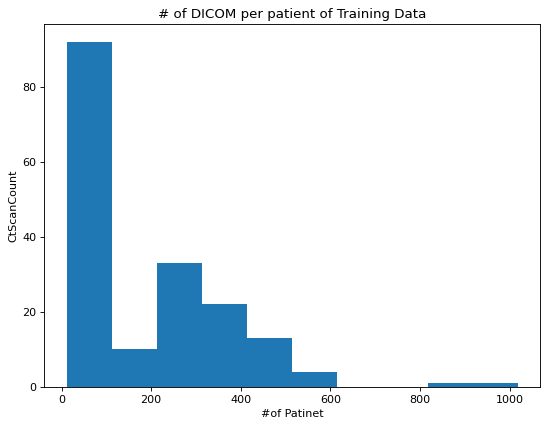

In [ ]:
plt.figure(figsize=(8,6), dpi= 80)
plt.hist('CtScanCount',data=patient_df)
plt.xlabel('#of Patinet')
plt.ylabel('CtScanCount')
plt.title('# of DICOM per patient of Training Data')

In [ ]:
# view the hidden information of a single DIOCOM file
dic=dicom.read_file('/content/drive/MyDrive/OSIC Pulmonary Fibrosis/train/ID00007637202177411956430/1.dcm')
print(dic)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 2.25.12297650151329871895440507938349160734
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.1
(0002, 0013) Implementation Version Name         SH: 'OSIRIX_361'
(0002, 0016) Source Application Entity Title     AE: 'ANONYMOUS'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0018) SOP Instance UID                    UI: 2.25.12297650151329871895440507938349160734
(0008, 0060) Modality                            CS: 'CT'
(0008, 0070) 

Let's make two helper functions.
(https://www.raddq.com/dicom-processing-segmentation-visualization-in-python/)
> ***load_dcm*** will load all DICOM images from a folder into a list for manipulation.

The voxel values in the images are raw. ***get_pixels_hu*** converts raw values into Houndsfeld units

*   The transformation is linear. Therefore, so long as you have a slope and an intercept, you can rescale a voxel value to HU.
*   Both the rescale intercept and rescale slope are stored in the DICOM header at the time of image acquisition (these values are scanner-dependent, so you will need external information).


In [ ]:
#https://www.raddq.com/dicom-processing-segmentation-visualization-in-python/

# Load the dcm in given folder path
def load_dcm(path):
  scans = os.listdir(path)  
  slices = []  
  for scan in scans:
    with dicom.dcmread(path + '/' + scan) as s:
      slices.append(s)
  slices.sort(key = lambda x: int(x.InstanceNumber))
  try:
    slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
  except:
    try:
      slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
    except:
      slice_thickness = slices[0].SliceThickness
  for s in slices:
    s.SliceThickness = slice_thickness      
  return slices

In [ ]:
dcm_read=[]
for patient in tqdm(patients):
  dcm_read.append(load_dcm(train_dir+patient))

 #### Converting DICOM Scan to HU Image
 The voxel values in the dicom image lists are raw and we need to convert these raw values into Hounsfield Units using the following function

In [ ]:
def get_pixels_hu(dcms):
    image = np.stack([s.pixel_array for s in dcms])
    image = image.astype(np.int16)
    image[image == -2000] = 0
    intercept = dcms[0].RescaleIntercept
    slope = dcms[0].RescaleSlope
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)     
    image += np.int16(intercept)
    return np.array(image, dtype=np.int16)

Compare Original Scan and HU Image

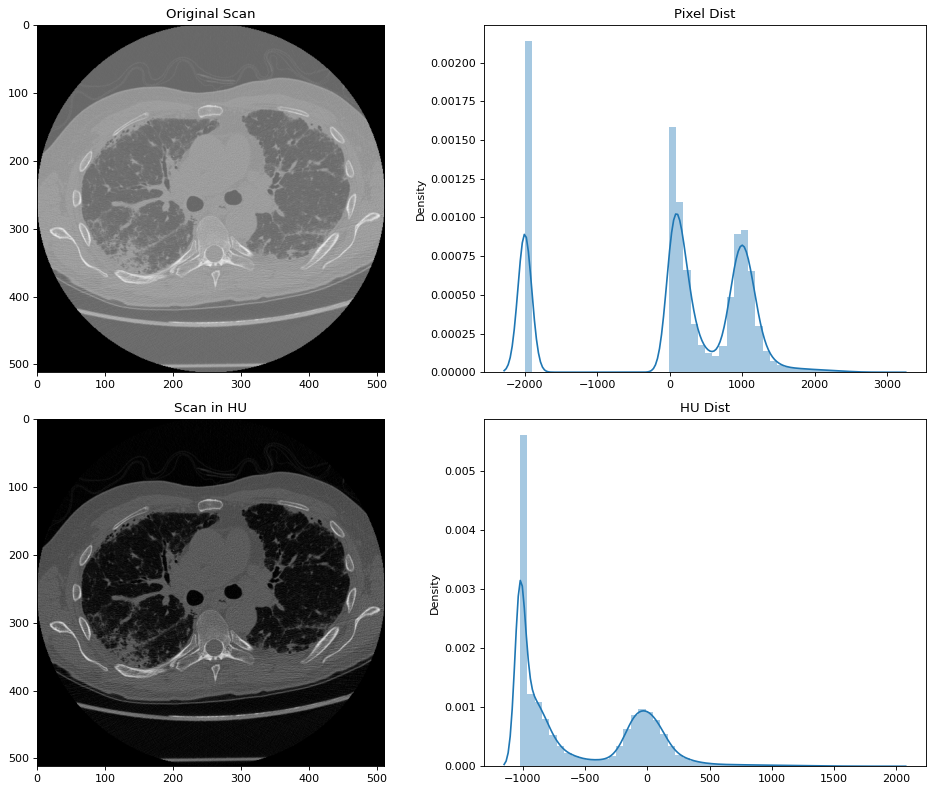

In [ ]:
patient_scans = load_dcm(train_dir+patients[0])
patient_hu = get_pixels_hu(patient_scans)
plt.figure(figsize=(12,10), dpi= 80)
plt.subplot(2, 2, 1)
plt.imshow(patient_scans[13].pixel_array, cmap=plt.cm.gray)
plt.title('Original Scan')
plt.subplot(2, 2, 2)
sns.distplot(patient_scans[13].pixel_array.flatten()).set_title('Pixel Dist')
plt.subplot(2, 2, 3)
plt.imshow(patient_hu[13], cmap=plt.cm.gray)
plt.title('Scan in HU')

plt.subplot(2, 2, 4)
sns.distplot(patient_hu[13].flatten()).set_title('HU Dist')
plt.tight_layout()


Checking with the HU table shows:

*   There is a lot of air, the peak around -1000
*   At around -500 there are some pixels classified as Lung;
*   The smaller gaussian-shaped peak at 0 indicates soft tissues;
*   The distribution tail from 700 onward shows the presence of bones.

In [ ]:
hu_image=[]
for patient in tqdm(patients):
  dcm_read=load_dcm(train_dir+patient)
  hu_image.append(get_pixels_hu(dcm_read))


  2%|▏         | 3/176 [06:00<3:57:03, 82.22s/it]

RuntimeError: ignored

Some of DICOM images are incomplete, they are missing required dependencies and instances. These DICOM need Grassroots DICOM (GDCM) library to be opened. The patients with with these issues or incomplete DICOM are patient ID 'ID00011637202177653955184' and 'ID00052637202186188008618'.

In [ ]:
#rerun the above code, excluding the the two patients
incomplete_scan=['ID00052637202186188008618','ID00011637202177653955184']
hu_image=[]
for patient in tqdm(patients):
  if patient not in incomplete_scan:
    dcm_read=load_dcm(train_dir+patient)
    hu_image.append(get_pixels_hu(dcm_read))

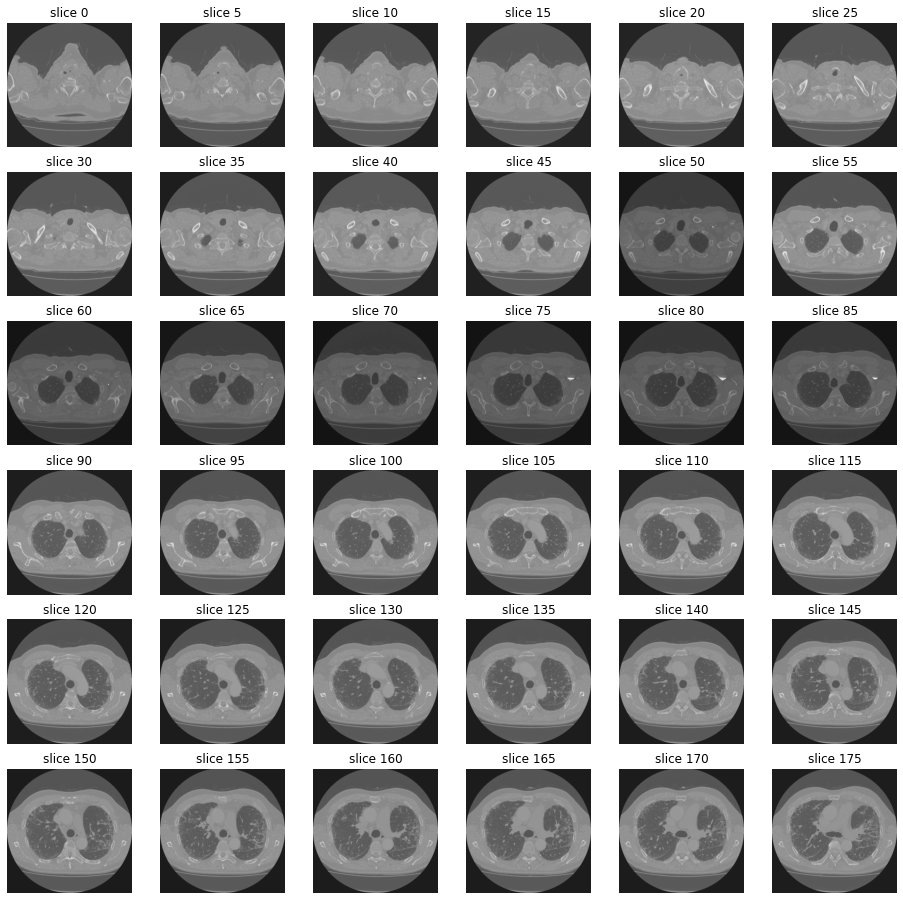

In [ ]:
#displaying image of patient ID00009637202177434476278 every five slices and see the difference.
patient_scans = load_dcm(train_dir + patients[60])
patient_hu = get_pixels_hu(patient_scans)
def sample_stack(stack, rows=6, cols=6, start_with=0, show_every=5):
  fig,ax = plt.subplots(rows,cols,figsize=[16,16])
  for i in range(rows*cols):
    ind = start_with + i*show_every
    ax[int(i/rows),int(i % rows)].set_title('slice %d' % ind)
    ax[int(i/rows),int(i % rows)].imshow(stack[ind],cmap='gray')
    ax[int(i/rows),int(i % rows)].axis('off')
  plt.show()

sample_stack(patient_hu)

### Resampling

A scan may have a pixel spacing of [2.5, 0.5, 0.5], which means that the distance between slices is 2.5 millimeters. For a different scan this may be [1.5, 0.725, 0.725], this can be problematic for automatic analysis (e.g. using ConvNets)!

A common method of dealing with this is resampling the full dataset to a certain isotropic resolution. If we choose to resample everything to 1mm1mm1mm pixels we can use 3D convnets without worrying about learning zoom/slice thickness invariance.

(https://www.kaggle.com/gzuidhof/full-preprocessing-tutorial)

In [ ]:
def resample(image, scan, new_spacing=[1,1,1]):
  spacing = map(float, ([scan[0].SliceThickness] + list(scan[0].PixelSpacing)))
  spacing = np.array(list(spacing))
    # Determine current pixel spacing
  resize_factor = spacing / new_spacing
  new_real_shape = image.shape * resize_factor
  new_shape = np.round(new_real_shape)
  real_resize_factor = new_shape / image.shape
  new_spacing = spacing / real_resize_factor
  image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
  return image, new_spacing

Displaying an image of patient ID00009637202177434476278 which has 394 dicom files. 

In [ ]:
#Applying the resample function on the first patinet
pix_resampled, spacing = resample(patient_hu, patient_scans, [1,1,1])
print("Shape before resampling\t", patient_hu.shape)
print("Shape after resampling\t", pix_resampled.shape)

Shape before resampling	 (407, 768, 768)
Shape after resampling	 (407, 351, 351)


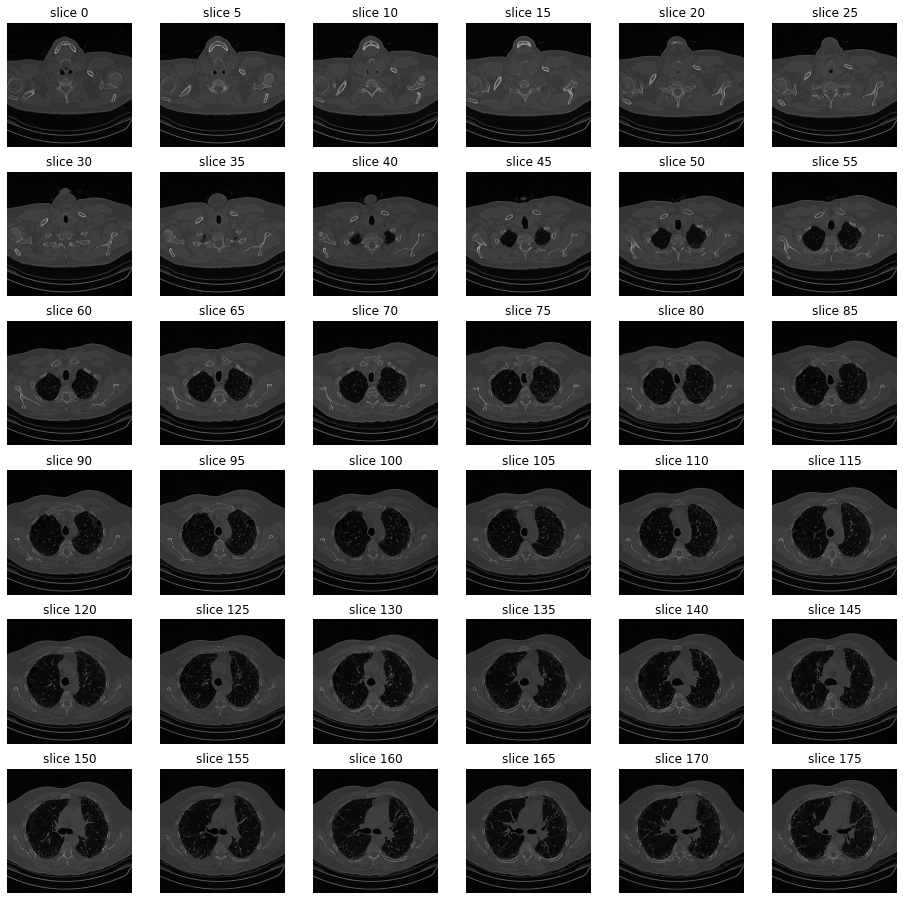

In [ ]:
#displaying image of patient ID00009637202177434476278 every five slices and see the difference.
patient_scans = load_dcm(train_dir + patients[1])
patient_hu = get_pixels_hu(patient_scans)
def sample_stack(stack, rows=6, cols=6, start_with=0, show_every=5):
  fig,ax = plt.subplots(rows,cols,figsize=[16,16])
  for i in range(rows*cols):
    ind = start_with + i*show_every
    ax[int(i/rows),int(i % rows)].set_title('slice %d' % ind)
    ax[int(i/rows),int(i % rows)].imshow(stack[ind],cmap='gray')
    ax[int(i/rows),int(i % rows)].axis('off')
  plt.show()

sample_stack(patient_hu)

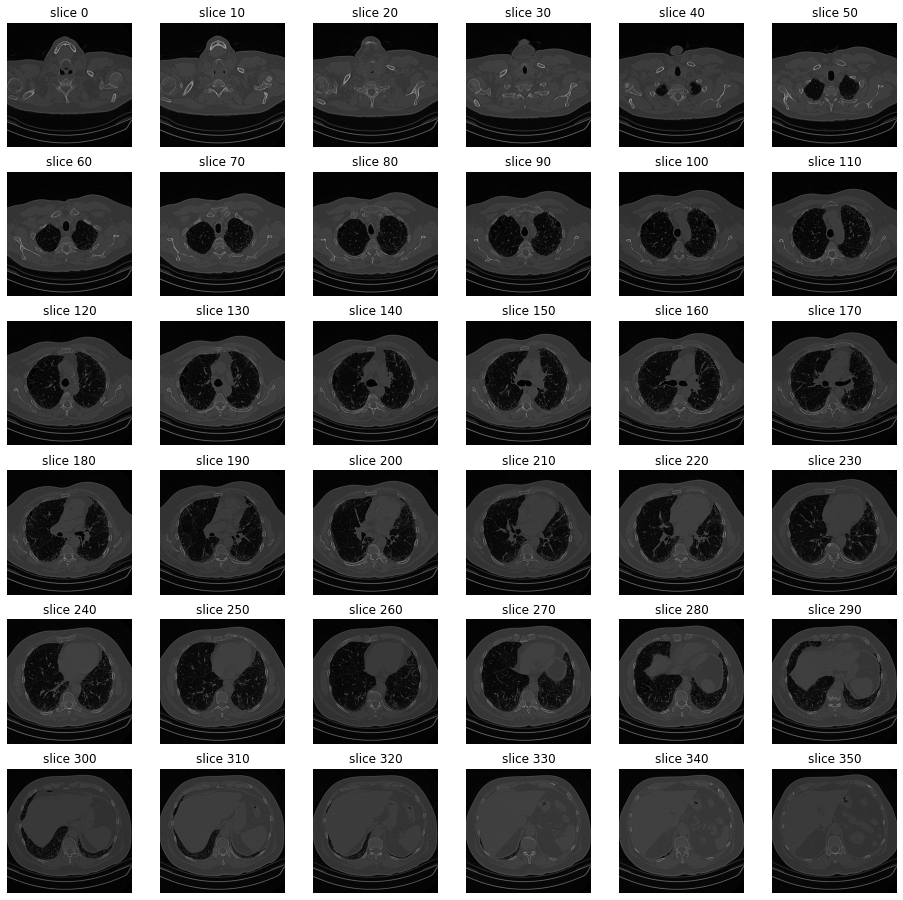

In [ ]:
#displaying image of patient ID00009637202177434476278 every ten slices.
patient_scans = load_dcm(train_dir + patients[1])
patient_hu = get_pixels_hu(patient_scans)
def sample_stack(stack, rows=6, cols=6, start_with=0, show_every=10):
  fig,ax = plt.subplots(rows,cols,figsize=[16,16])
  for i in range(rows*cols):
    ind = start_with + i*show_every
    ax[int(i/rows),int(i % rows)].set_title('slice %d' % ind)
    ax[int(i/rows),int(i % rows)].imshow(stack[ind],cmap='gray')
    ax[int(i/rows),int(i % rows)].axis('off')
  plt.show()

sample_stack(patient_hu)

In [ ]:
incomplete_scan=['ID00052637202186188008618','ID00011637202177653955184']
resampled=[]
for patient in patients[:15]:
  if patient not in incomplete_scan:
    patients_scans=load_dcm(train_dir+patient)
    patients_hu=get_pixels_hu(patients_scans)
    pix_resampled, spacing = resample(patients_hu, patients_scans, [1,1,1])
    resampled.append(pix_resampled)

In [ ]:
def plot_3d(image, threshold=700):   
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    verts, faces, norm, val = measure.marching_cubes_lewiner(p, threshold, allow_degenerate=True)
    fig = plt.figure(figsize=(10, 10))
    bg = np.array((30, 39, 46))/255.0
    ax = fig.add_subplot(111, projection='3d')
    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)
    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

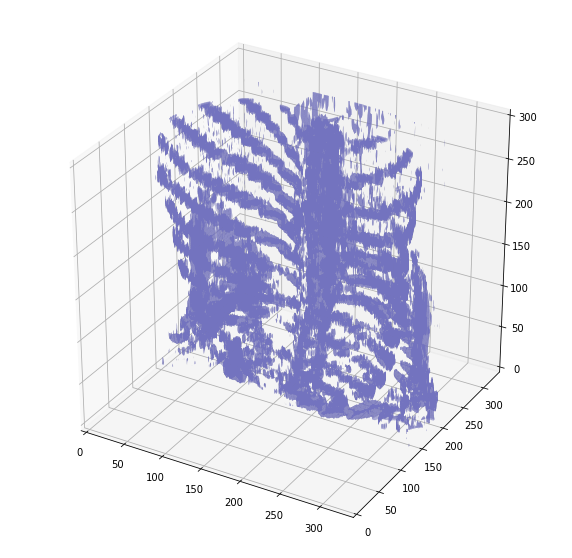

In [ ]:
plot_3d(resampled[0], 700)

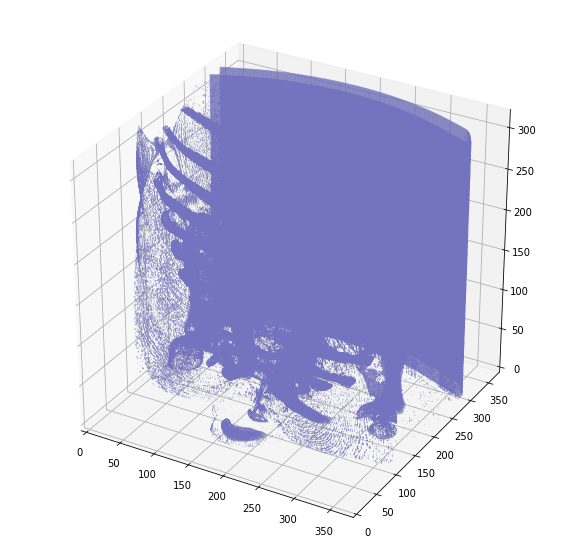

In [ ]:
plot_3d(resampled[1], 700)

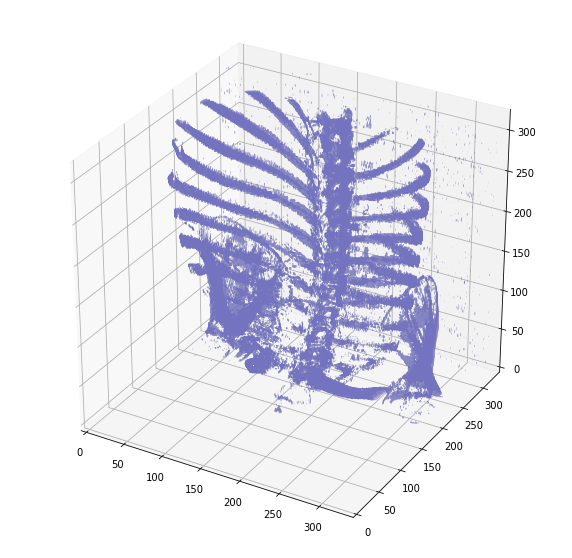

In [ ]:
plot_3d(resampled[2], 700)

In [ ]:
#convert the dictionary to DataFame to pickle the file
resampled=pd.DataFrame.from_dict(pix_resample)
#let's pickle for later use
resampled.to_pickle("sampled.pkl")

import pickle
DATA_PATH = "/content/drive/My Drive/resampled.pkl"
infile = open(DATA_PATH,'rb')
resample = pickle.load(infile)

# Segmentation
Machine learning algorithms work a lot better when we narrowly define what it is looking at. One way to do this is by  segmenting the lungs (and usually some tissue around it) or by applying a mask onto the original image to erase voxels outside of the lung fields. The purpose of segmenting or masking is to auto-detect the boundaries surrounding a volume of interest (our case is the lungs

In [ ]:
def largest_label_volume(im, bg=-1):
  vals, counts = np.unique(im, return_counts=True)
  counts = counts[vals != bg]
  vals = vals[vals != bg]
  biggest = vals[np.argmax(counts)]
  return biggest

def segment_lung_mask(image, fill_lung_structures=True):
  binary_image = np.array(image > -320, dtype=np.int8)+1
  labels = measure.label(binary_image)
  background_label = labels[0,0,0]
  binary_image[background_label == labels] = 2   
  if fill_lung_structures:
    for i, axial_slice in enumerate(binary_image):
      axial_slice = axial_slice - 1
      labeling = measure.label(axial_slice)
      l_max = largest_label_volume(labeling, bg=0)   
      if l_max is not None: 
        binary_image[i][labeling != l_max] = 1
  binary_image -= 1 
  binary_image = 1-binary_image 
  labels = measure.label(binary_image, background=0)
  l_max = largest_label_volume(labels, bg=0)
  if l_max is not None: 
    binary_image[labels != l_max] = 0
 
  return binary_image

In [ ]:
#After getting rid of the incomplete scans of two patients with ID 'ID00052637202186188008618' and 'ID00011637202177653955184'
incomplete_scan=['ID00052637202186188008618','ID00011637202177653955184']
dict_dicom={"Patient":[], "Imgs":[]}
for patient in patients[:10]:
  if patient not in incomplete_scan:
    patients_scans=load_dcm(train_dir+patient)
    patients_hu=get_pixels_hu(patients_scans)
    pix_resample, spacing = resample(patients_hu, patients_scans, [1,1,1])
    segmented_lung=segment_lung_mask(pix_resample, False)
    segmented_lung_fill=segment_lung_mask(pix_resample, True)
    masked_lung = segmented_lung_fill-segmented_lung
    dict_dicom["Imgs"].append(masked_lung)
    dict_dicom["Patient"].append(patient)

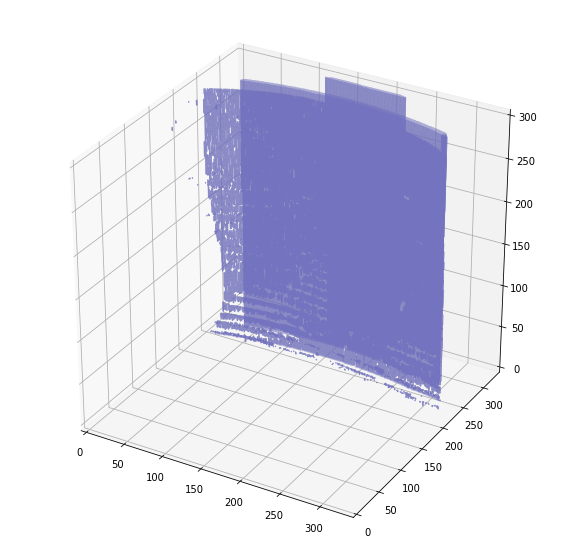

In [ ]:
plot_3d(dict_dicom['Imgs'][0],0)

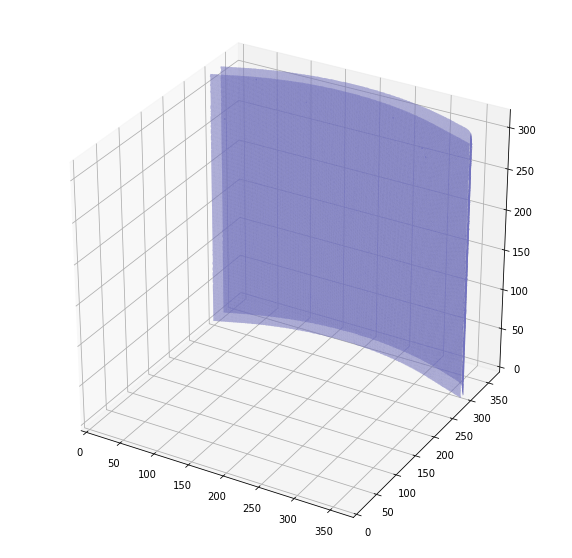

In [ ]:
plot_3d(dict_dicom['Imgs'][1],0)

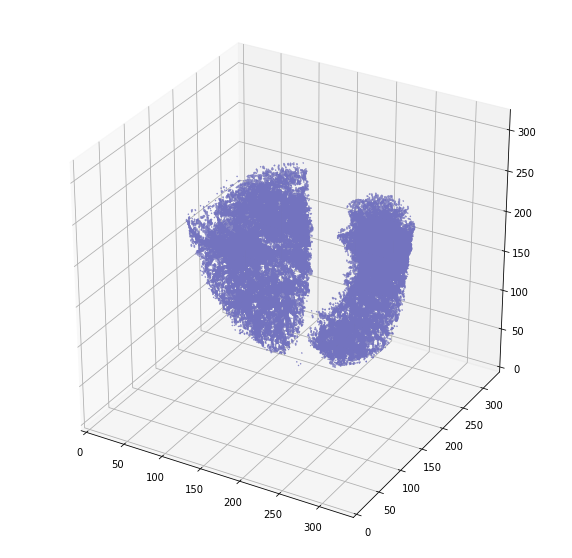

In [ ]:
plot_3d(dict_dicom['Imgs'][2],0)

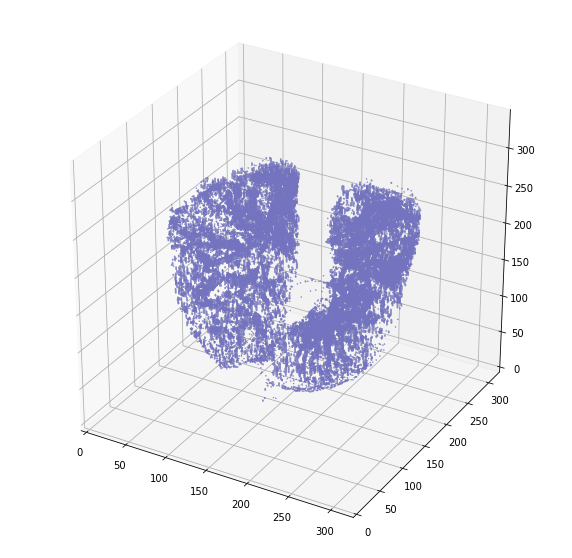

In [ ]:
plot_3d(dict_dicom['Imgs'][3],0)

Looking at the 3D plot of segmented images, the function used to segment a part of lungs leaving the rest up for grabs didn't work here. So let's count the binary image pixel in each image and see the unique pixel ratio (pr).

In [ ]:
#calculate the unique counts of the first segmented images
unique, counts = np.unique(dict_dicom['Imgs'][0], return_counts=True)
pr=dict(zip(unique, counts))
pr[0]/pr[1]

67.30670130972815

In [ ]:
#calculate the unique counts of the second segmented images
unique, counts = np.unique(dict_dicom['Imgs'][1], return_counts=True)
pr=dict(zip(unique, counts))
pr[0]/pr[1]

15.060342734836494

In [ ]:
#calculate the unique counts of the third segmented images
unique, counts = np.unique(dict_dicom['Imgs'][2], return_counts=True)
p=dict(zip(unique, counts))
p[0]/p[1]

225.80362249761677

In [ ]:
#calculate the unique counts of the fourth segmented images
unique, counts = np.unique(dict_dicom['Imgs'][3], return_counts=True)
a=dict(zip(unique, counts))
a[0]/a[1]

391.45991396167386

After calculating the ratio pr(pixel ratio) for a sample of data, we noticed that a ratio greater than approximately 100 seems segments the lung part from the image.

In [ ]:
#rerun the extracting segmented image after setting the unique binary pixel count ratio condirion

dict_dicom={"Patient":[], "Imgs":[]}
for patient in patients[:15]:
  if patient not in incomplete_scan:
    patients_scans=load_dcm(train_dir+patient)
    patients_hu=get_pixels_hu(patients_scans)
    pix_resample, spacing = resample(patients_hu, patients_scans, [1,1,1])
    segmented_lung=segment_lung_mask(pix_resample, False)
    segmented_lung_fill=segment_lung_mask(pix_resample, True)
    masked_lung = segmented_lung_fill-segmented_lung
    unique, counts = np.unique(masked_lung, return_counts=True)
    pr=dict(zip(unique, counts))
    if (pr[0]/pr[1]<=100 and pr[1]!=0):
      dict_dicom["Imgs"].append(masked_lung)
      dict_dicom["Patient"].append(patient)

segmented=pd.DataFrame.from_dict(dict_dicom)

#let's pickle for later use
segmented.to_pickle("segmented.pkl")

By stricting the number of pixel additional ten ID's added to the incomplete scan as they fail to satisfy the condition setted for the pixel ratio. 

In [ ]:
incomplete_scan=['ID00132637202222178761324','ID00128637202219474716089','ID00052637202186188008618','ID00026637202179561894768','ID00011637202177653955184',
                 'ID00173637202238329754031','ID00027637202179689871102','ID00123637202217151272140','ID00136637202224951350618','ID00183637202241995351650',
                 'ID00222637202259066229764','ID00224637202259281193413']

In [ ]:
import pickle
DATA_PATH0 = "/content/drive/My Drive/segmented.pkl"
infile0 = open(DATA_PATH0,'rb')
imgs_df = pickle.load(infile0)

In [ ]:
#the size of data
print(imgs_df.shape)


(164, 2)


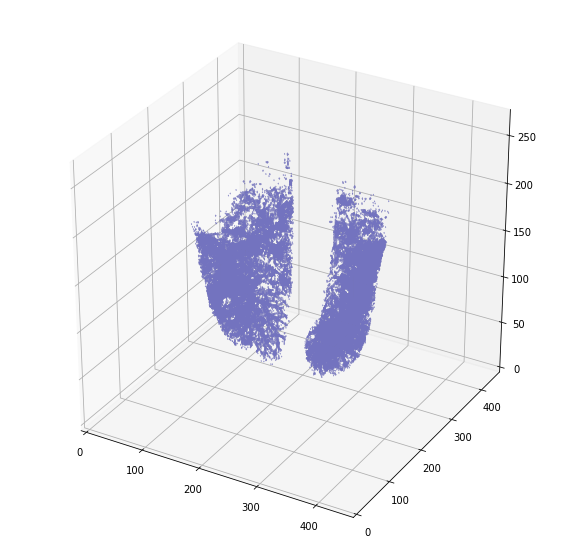

In [ ]:
plot_3d(imgs_df['Imgs'][0],0)



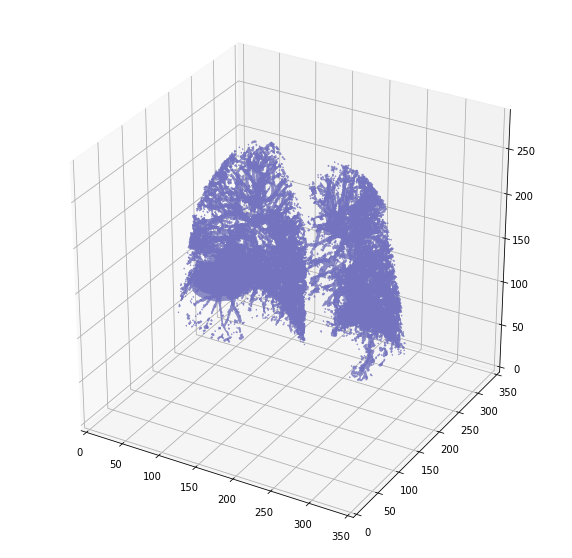

In [ ]:
plot_3d(imgs_df['Imgs'][1],0)

#Convolutional Neural Network (CNN) Model

Encoding the categorical features and standidize the numerical feaures before modeling 

In [ ]:
df_train=pd.read_csv('/content/drive/MyDrive/OSIC Pulmonary Fibrosis/train.csv')
#vectorize the categorical features and normilize
def get_tab(df):
    vector = [(df.Age.values[0] - 30) / 30] 
    if df.Sex.values[0] == 'male':
       vector.append(0)
    else:
       vector.append(1)   
    if df.SmokingStatus.values[0] == 'Never smoked':
        vector.extend([0,0])
    elif df.SmokingStatus.values[0] == 'Ex-smoker':
        vector.extend([1,1])
    elif df.SmokingStatus.values[0] == 'Currently smokes':
        vector.extend([0,1])
    else:
        vector.extend([1,0])
    return np.array(vector) 

In [ ]:
A = {} 
TAB = {} 
P = [] 
for i, p in tqdm(enumerate(df_train.Patient.unique())):
    sub = df_train.loc[df_train.Patient == p, :] 
    fvc = sub.FVC.values
    weeks = sub.Weeks.values
    c = np.vstack([weeks, np.ones(len(weeks))]).T
    a, b = np.linalg.lstsq(c, fvc)[0]
    
    A[p] = a
    TAB[p] = get_tab(sub)
    P.append(p)

In [ ]:
def get_img(path):
    d = pydicom.dcmread(path)
    return cv2.resize(d.pixel_array / 2**11, (512, 512))

Sequence are a safer way to do multiprocessing. This structure guarantees that the network will only train once on each sample per epoch which is not the case with generators. Every Sequence must implement the getitem and the len methods. If we want to modify our dataset between epochs we may implement on_epoch_end. The method getitem should return a complete batch. We used a batch size of 32 which means the number of samples that will be propagated through the network is 32.

In [ ]:
class IGenerator(Sequence):
    BAD_ID = incomplete_scan
    def __init__(self, keys, a, tab, batch_size=32):
        self.keys = [k for k in keys if k not in self.BAD_ID]
        self.a = a
        self.tab = tab
        self.batch_size = batch_size
        
        self.train_data = {}
        for p in df_train.Patient.values:
            self.train_data[p] = os.listdir(f'/content/drive/My Drive/OSIC Pulmonary Fibrosis/train/{p}/')
    
    def __len__(self):
        return 1000
    
    def __getitem__(self, idx):
        x = []
        a, tab = [], [] 
        keys = np.random.choice(self.keys, size = self.batch_size)
        for k in keys:
            try:
                i = np.random.choice(self.train_data[k], size=1)[0]
                img = get_img(f'/content/drive/My Drive/OSIC Pulmonary Fibrosis/train/{k}/{i}')
                x.append(img)
                a.append(self.a[k])
                tab.append(self.tab[k])
            except:
                print(k, i)
       
        x,a,tab = np.array(x), np.array(a), np.array(tab)
        x = np.expand_dims(x, axis=-1)
        return [x, tab] , a

In [ ]:
def get_model(shape=(512, 512, 1)):
    def res_block(x, n_features):
        _x = x
        x = BatchNormalization()(x)
        x = LeakyReLU(0.05)(x)
    
        x = Conv2D(n_features, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
        x = Add()([_x, x])
        return x
    
    inp = Input(shape=shape)
    
    x = Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same')(inp)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.05)(x)
    
    x = Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.05)(x)
    
    x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)
   
    x = Conv2D(8, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    for _ in range(2):
        x = res_block(x, 8)
    x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    
    x = Conv2D(16, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    for _ in range(2):
        x = res_block(x, 16)
    x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)
  
    x = Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    for _ in range(3):
        x = res_block(x, 32)
    x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)
  
    x = Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    for _ in range(3):
        x = res_block(x, 64)
    x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)    
  
    x = Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    for _ in range(3):
        x = res_block(x, 128)
    
    x = GlobalAveragePooling2D()(x)
    
    inp2 = Input(shape=(4,))
    x2 = tf.keras.layers.GaussianNoise(0.2)(inp2)
    x = Concatenate()([x, x2]) 
    x = Dropout(0.6)(x) 
    x = Dense(1)(x)
    #x2 = Dense(1)(x)
    return Model([inp, inp2] , x)

In [ ]:
model = get_model() 
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 32) 320         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 512, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 512, 512, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mae') 
from sklearn.model_selection import train_test_split 

tr_p, vl_p = train_test_split(P, shuffle=True, train_size= 0.8, random)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


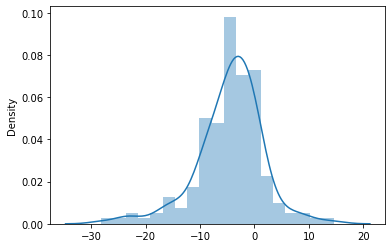

In [ ]:
#Let's see the standardized FVC distribution

sns.distplot(list(A.values()));

In [ ]:
er = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=1e-3,
    patience=5,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

Train the model

In [ ]:
history=model.fit_generator(IGenerator(keys=tr_p, 
                               a = A, 
                               tab = TAB), 
                    steps_per_epoch = 50,
                    validation_data=IGenerator(keys=vl_p, 
                               a = A, 
                               tab = TAB),
                    validation_steps = 20, 
                    callbacks = [er], 
                    epochs=30)

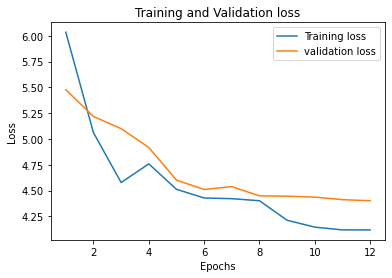

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,13)
plt.plot(epochs, loss_train, label='Training loss')
plt.plot(epochs, loss_val, label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Elavuation Metrics

Predictions are evaluated with a modified version of the Laplace Log Likelihood. For each sample in test set, an `FVC` and a `Confidence` measure (standard deviation σ) has to be predicted.

`Confidence` values smaller than 70 are clipped.


$\large \sigma_{clipped} = max(\sigma, 70),$

Errors greater than 1000 are also clipped in order to avoid large errors.

$\large \Delta = min ( |FVC_{true} - FVC_{predicted}|, 1000 ),$

The metric is defined as:

$\Large metric = -   \frac{\sqrt{2} \Delta}{\sigma_{clipped}} - \ln ( \sqrt{2} \sigma_{clipped} ).$

The metric is implemented below and theoretical minimum score is calculated.

In [ ]:
#Define the evaluation metrics
def score(fvc_true, fvc_pred, sigma):
    sigma_clip = np.maximum(sigma, 70)
    delta = np.abs(fvc_true - fvc_pred)
    delta = np.minimum(delta, 1000)
    sq2 = np.sqrt(2)
    metric = (delta / sigma_clip)*sq2 + np.log(sigma_clip* sq2)
    return np.mean(metric)

In [ ]:
metric = []
for q in tqdm(range(1, 10)):
    m = []
    for p in vl_p:
        x = [] 
        tab = [] 
        
        if p in incomplete_scan:
            continue
        for i in os.listdir(f'/content/drive/MyDrive/OSIC Pulmonary Fibrosis/train/{p}/'):
            x.append(get_img(f'/content/drive/MyDrive/OSIC Pulmonary Fibrosis/train/{p}/{i}')) 
            tab.append(get_tab(df_train.loc[df_train.Patient == p, :])) 
        tab = np.array(tab) 
    
        x = np.expand_dims(x, axis=-1) 
        _a = model.predict([x, tab]) 
        a = np.quantile(_a, q / 10)
        
        percent_true = df_train.Percent.values[df_train.Patient == p]
        fvc_true = df_train.FVC.values[df_train.Patient == p]
        weeks_true = df_train.Weeks.values[df_train.Patient == p]
        
        fvc = a * (weeks_true - weeks_true[0]) + fvc_true[0]
        percent = percent_true[0] - a * abs(weeks_true - weeks_true[0])
        m.append(score(fvc_true, fvc, percent))
    print(np.mean(m))
    metric.append(np.mean(m))

6.9915418649911665
6.992761124234116
6.994318691885722
6.994812376674707
6.995251904777802
6.996139395950844
6.997287006838486
6.998818972138642
6.999801353848182



## Predictions

In [ ]:
q = (np.argmin(metric) + 1)/ 10
A_test, B_test, P_test,W, FVC= {}, {}, {},{},{} 
STD, WEEK = {}, {} 
for p in test.Patient.unique():
    x = [] 
    tab = [] 
    for i in os.listdir(f'/content/drive/My Drive/OSIC Pulmonary Fibrosis/test/{p}/'):
        x.append(get_img(f'/content/drive/My Drive/OSIC Pulmonary Fibrosis/test/{p}/{i}')) 
        tab.append(get_tab(test.loc[test.Patient == p, :])) 
    tab = np.array(tab) 
            
    x = np.expand_dims(x, axis=-1) 
    _a = model.predict([x, tab]) 
    a = np.quantile(_a, q)
    A_test[p] = a
    B_test[p] = test.FVC.values[test.Patient == p] - a*test.Weeks.values[test.Patient == p]
    P_test[p] = test.Percent.values[test.Patient == p] 
    WEEK[p] = test.Weeks.values[test.Patient == p]

In [ ]:

for k in sub.Patient_Week.values:
    p, w = k.split('_')
    w = int(w) 
    
    fvc = A_test[p] * w + B_test[p]
    sub.loc[sub.Patient_Week == k, 'FVC'] = fvc
    sub.loc[sub.Patient_Week == k, 'Confidence'] = (
        P_test[p] - A_test[p] * abs(WEEK[p] - w) 
)

In [ ]:
sub[["Patient_Week","FVC","Confidence"]].to_csv("submission.csv", index=False)

In [ ]:
final_result=pd.read_csv('/content/submission.csv')
final_result.head(10)

Patient_Week          FVC  Confidence
0  ID00419637202311204720264_-12  3077.136084  127.322939
1  ID00421637202311550012437_-12  2824.307741  167.353032
2  ID00422637202311677017371_-12  1989.162334  135.834827
3  ID00423637202312137826377_-12  3386.956645  172.215548
4  ID00426637202313170790466_-12  2962.695335  109.520303
5  ID00419637202311204720264_-11  3073.961857  124.148712
6  ID00421637202311550012437_-11  2821.148195  164.193486
7  ID00422637202311677017371_-11  1985.875538  132.548031
8  ID00423637202312137826377_-11  3383.751244  169.010147
9  ID00426637202313170790466_-11  2959.554057  106.379025